In [7]:
import os

base_dir = '/kaggle/input/flowers-dataset/'

# Xem toàn bộ nội dung
print(os.listdir(base_dir))

# Chỉ duyệt thư mục con (train, test)
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):  # chỉ lấy thư mục
        print(folder, ":", len(os.listdir(folder_path)), "images or subfolders")


['sample_submission.csv', 'Testing_set_flower.csv', 'LICENSE.txt', 'test', 'train']
test : 924 images or subfolders
train : 5 images or subfolders


**phân tích nguyên liệu**

Các lớp hoa trong dataset: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
Số lớp: 5

Số lượng ảnh trong mỗi lớp:
dandelion: 646
daisy: 501
sunflower: 495
tulip: 607
rose: 497


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


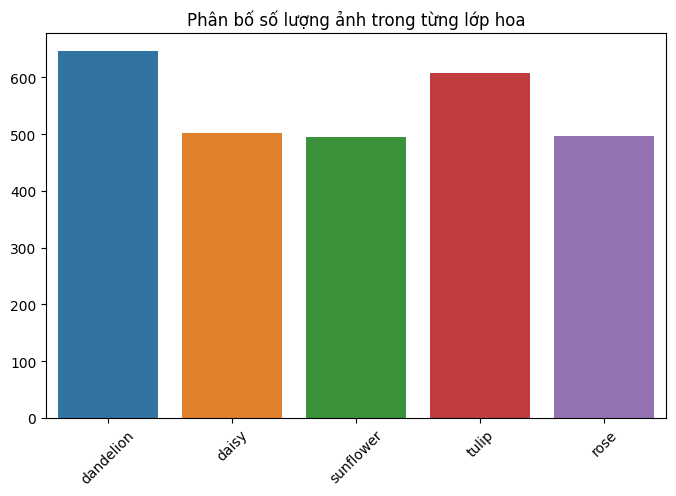

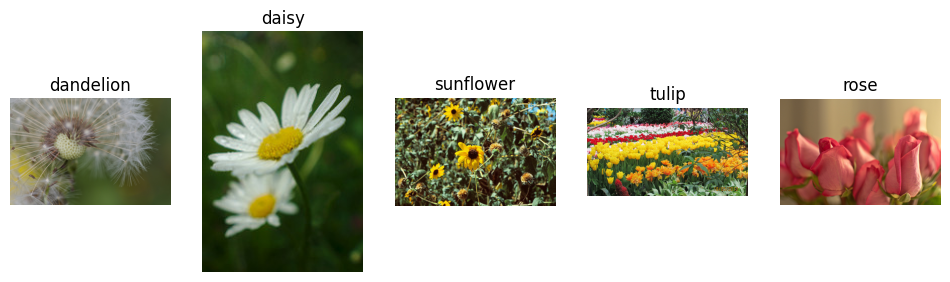

Chiều rộng trung bình: 396.0, chiều cao trung bình: 278.6


In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import numpy as np

train_dir = '/kaggle/input/flowers-dataset/train'

# 1️⃣ Danh sách các lớp hoa
classes = os.listdir(train_dir)
print(f"Các lớp hoa trong dataset: {classes}")
print("Số lớp:", len(classes))

# 2️⃣ Đếm số ảnh trong từng lớp
num_images = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
print("\nSố lượng ảnh trong mỗi lớp:")
for cls, count in num_images.items():
    print(f"{cls}: {count}")

# Vẽ biểu đồ phân bố ảnh
plt.figure(figsize=(8,5))
sns.barplot(x=list(num_images.keys()), y=list(num_images.values()))
plt.xticks(rotation=45)
plt.title("Phân bố số lượng ảnh trong từng lớp hoa")
plt.show()

# 3️⃣ Hiển thị một vài ảnh mẫu
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes[:5]):  # chỉ hiển thị 5 lớp đầu
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.show()

# 4️⃣ Kiểm tra kích thước ảnh trung bình
sizes = []
for cls in classes:
    img_folder = os.path.join(train_dir, cls)
    sample_img = Image.open(os.path.join(img_folder, os.listdir(img_folder)[0]))
    sizes.append(sample_img.size)

widths, heights = zip(*sizes)
print(f"Chiều rộng trung bình: {np.mean(widths):.1f}, chiều cao trung bình: {np.mean(heights):.1f}")


In [13]:
# Cell 3: Import các thư viện cần thiết cho mô hình
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models


In [14]:
# Cell 4: Thiết lập các hằng số và tạo Data Generators

# --- 1. Thiết lập các hằng số ---
# Sử dụng lại biến train_dir từ cell trước của bạn
# train_dir = '/kaggle/input/flowers-dataset/train' # Dòng này bạn đã có ở cell trước

IMG_HEIGHT = 224 # Chiều cao mục tiêu của ảnh
IMG_WIDTH = 224  # Chiều rộng mục tiêu của ảnh
BATCH_SIZE = 32  # Số ảnh trong mỗi lần huấn luyện (mỗi lô)
VAL_SPLIT = 0.2  # Tỷ lệ dữ liệu dùng cho tập validation (20%)

# --- 2. Tạo ImageDataGenerator với Data Augmentation ---
# Chúng ta sẽ áp dụng các phép biến đổi để dữ liệu đa dạng hơn, giúp mô hình chống học vẹt
datagen = ImageDataGenerator(
    rescale=1./255,                 # Chuẩn hóa giá trị pixel về [0, 1]
    rotation_range=30,              # Xoay ảnh ngẫu nhiên lên đến 30 độ
    width_shift_range=0.2,          # Dịch ngang ảnh
    height_shift_range=0.2,         # Dịch dọc ảnh
    shear_range=0.2,                # Biến dạng cắt ảnh (làm nghiêng ảnh)
    zoom_range=0.2,                 # Phóng to/thu nhỏ ảnh
    horizontal_flip=True,           # Lật ảnh theo chiều ngang
    fill_mode='nearest',            # Lấp đầy các pixel bị thiếu sau khi biến đổi
    validation_split=VAL_SPLIT      # Tự động tách dữ liệu thành tập train và validation
)

# --- 3. Tạo các luồng dữ liệu (Data Generators) từ thư mục ---
print("Đang tạo luồng dữ liệu cho tập huấn luyện:")
train_generator = datagen.flow_from_directory(
    train_dir,                      # Đường dẫn đến thư mục train
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize tất cả ảnh về kích thước này
    batch_size=BATCH_SIZE,
    class_mode='categorical',       # Vì đây là bài toán phân loại đa lớp
    subset='training',              # Đánh dấu đây là tập huấn luyện
    seed=42                         # Đặt seed để kết quả có thể tái tạo
)

print("\nĐang tạo luồng dữ liệu cho tập kiểm định:")
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # Đánh dấu đây là tập kiểm định
    shuffle=False,                  # Không cần xáo trộn tập validation khi đánh giá
    seed=42
)

# In ra các lớp để kiểm tra
class_names = list(train_generator.class_indices.keys())
print("\nCác lớp đã được tìm thấy:", class_names)

Đang tạo luồng dữ liệu cho tập huấn luyện:
Found 2198 images belonging to 5 classes.

Đang tạo luồng dữ liệu cho tập kiểm định:
Found 548 images belonging to 5 classes.

Các lớp đã được tìm thấy: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [15]:
# Cell 5: Xây dựng mô hình CNN cải tiến

model = Sequential([
    # Input Layer
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # --- Block 1 ---
    # Lớp Conv2D đầu tiên để học các đặc trưng cơ bản
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(), # CẢI TIẾN: Thêm BatchNormalization
    MaxPooling2D(),

    # --- Block 2 ---
    # Tăng số bộ lọc để học đặc trưng phức tạp hơn
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(), # CẢI TIẾN: Thêm BatchNormalization
    MaxPooling2D(),

    # --- Block 3 (Sâu hơn) ---
    # Thêm 2 lớp Conv2D để học đặc trưng sâu hơn nữa
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    # --- Block 4 (Sâu hơn nữa) ---
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    # --- Lớp phân loại (Classifier) ---
    Flatten(), # Duỗi các đặc trưng thành vector 1D
    
    # Lớp Dense để kết hợp các đặc trưng
    Dense(512, activation='relu'),
    BatchNormalization(), # CẢI TIẾN: Thêm BatchNormalization
    
    # CẢI TIẾN: Tăng Dropout để chống học vẹt tốt hơn
    Dropout(0.5), 
    
    # Lớp Output với 5 nơ-ron cho 5 loại hoa
    Dense(len(class_names), activation='softmax')
])

# In ra cấu trúc của mô hình để kiểm tra
model.summary()

I0000 00:00:1760310801.186765      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760310801.187460      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,233,669 (100.07 MB)

 Trainable params: 26,231,429 (100.06 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [16]:
# Cell 6: Compile và Huấn luyện Mô hình

# --- 1. Compile mô hình ---
# Cấu hình các công cụ cần thiết cho việc học
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 2. Thiết lập Early Stopping ---
# Cơ chế này sẽ dừng huấn luyện nếu val_loss không cải thiện sau 5 epochs
# và sẽ khôi phục lại trọng số của epoch tốt nhất.
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# --- 3. Bắt đầu huấn luyện ---
# Huấn luyện với số epochs lớn (ví dụ: 50), nhưng EarlyStopping sẽ tìm điểm dừng tối ưu
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping] # Gắn "người giám sát" EarlyStopping vào quá trình huấn luyện
)

# --- 4. Đánh giá nhanh kết quả cuối cùng trên tập validation ---
print("\nĐánh giá lại mô hình trên tập validation với trọng số tốt nhất:")
final_loss, final_accuracy = model.evaluate(validation_generator)
print(f"\nĐộ chính xác cuối cùng trên tập validation: {final_accuracy*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1760310954.308997     145 service.cc:148] XLA service 0x793b38002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760310954.310619     145 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760310954.310642     145 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760310955.099910     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/69 ━━━━━━━━━━━━━━━━━━━━ 19:12 17s/step - accuracy: 0.2500 - loss: 2.3027

I0000 00:00:1760310964.645043     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.3899 - loss: 2.1884 - val_accuracy: 0.2354 - val_loss: 2.2805
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 501ms/step - accuracy: 0.5357 - loss: 1.3898 - val_accuracy: 0.2354 - val_loss: 3.1642
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 490ms/step - accuracy: 0.5870 - loss: 1.1556 - val_accuracy: 0.2354 - val_loss: 3.6471
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 494ms/step - accuracy: 0.6250 - loss: 1.0625 - val_accuracy: 0.3084 - val_loss: 2.1100
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 490ms/step - accuracy: 0.6470 - loss: 0.9984 - val_accuracy: 0.2810 - val_loss: 2.6283
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 490ms/step - accuracy: 0.6608 - loss: 0.9495 - val_accuracy: 0.3978 - val_loss: 1.6582
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - accuracy: 0.6455 - loss: 0.9280 - val_accuracy: 0.4380 - val_loss: 1.5047
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - accuracy: 0.6725 - loss: 0.8822 - val_accuracy: 0.5675 -

**Xây dựng mô hình với Transfer Learning (MobileNetV2)**

In [17]:
# Cell 7: Xây dựng mô hình với Transfer Learning (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2

# --- 1. Tải mô hình MobileNetV2 đã được huấn luyện trước ---
# include_top=False: Bỏ lớp phân loại cuối cùng (1000 lớp của ImageNet)
# weights='imagenet': Tải các trọng số đã được huấn luyện trên ImageNet
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# --- 2. Đóng băng các lớp của base_model ---
# Chúng ta sẽ không huấn luyện lại các lớp này ở bước đầu
base_model.trainable = False

# --- 3. Xây dựng mô hình mới bằng cách thêm các lớp phân loại của chúng ta ---
model_mobilenet = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Gom các đặc trưng lại một cách hiệu quả
    Dropout(0.5),                    # Lớp Dropout để chống overfitting
    Dense(len(class_names), activation='softmax') # Lớp output cho 5 loại hoa
])

# --- 4. In ra cấu trúc mô hình ---
# Chú ý sự khác biệt giữa "Total params" và "Trainable params"
print("Cấu trúc mô hình MobileNetV2:")
model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Cấu trúc mô hình MobileNetV2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
# Cell 8: Compile và Huấn luyện mô hình MobileNetV2

# --- 1. Compile mô hình ---
model_mobilenet.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# --- 2. Thiết lập lại Early Stopping ---
# Vẫn sử dụng cơ chế tương tự để tìm điểm dừng tốt nhất
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, # Dừng lại nếu sau 5 epochs val_loss không cải thiện
                               restore_best_weights=True,
                               verbose=1)

# --- 3. Bắt đầu huấn luyện (chỉ huấn luyện các lớp mới thêm vào) ---
print("Bắt đầu giai đoạn Feature Extraction...")

# Đặt số epochs là 20, EarlyStopping sẽ giúp chúng ta dừng sớm nếu cần
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# --- 4. Đánh giá nhanh kết quả sau khi huấn luyện ---
print("\nĐánh giá mô hình trên tập validation:")
final_loss, final_accuracy = model_mobilenet.evaluate(validation_generator)
print(f"\nĐộ chính xác trên tập validation sau Feature Extraction: {final_accuracy*100:.2f}%")

Bắt đầu giai đoạn Feature Extraction...
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 0.4302 - loss: 1.5348 - val_accuracy: 0.7591 - val_loss: 0.6715
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.7241 - loss: 0.7757 - val_accuracy: 0.8029 - val_loss: 0.5493
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 481ms/step - accuracy: 0.7732 - loss: 0.5955 - val_accuracy: 0.8212 - val_loss: 0.5011
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 476ms/step - accuracy: 0.7901 - loss: 0.5754 - val_accuracy: 0.8412 - val_loss: 0.4581
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 481ms/step - accuracy: 0.7977 - loss: 0.5551 - val_accuracy: 0.8412 - val_loss: 0.4427
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 478ms/step - accuracy: 0.8233 - loss: 0.4866 - val_accuracy: 0.8540 - val_loss: 0.4357
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 481ms/step - accuracy: 0.8288 - loss: 0.4492 - val_accuracy: 0.8285 - val_loss: 0.4753
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 475ms/step - ac

# **Fine-tuning mô hình MobileNetV2**

In [19]:
# Cell 9: Fine-tuning mô hình MobileNetV2

# --- 1. Mở băng các lớp trên cùng của base_model ---
# Chúng ta sẽ chỉ huấn luyện lại một vài lớp cuối
base_model.trainable = True

# Hãy xem có bao nhiêu lớp trong mô hình cơ sở
print(f"Số lớp trong base_model: {len(base_model.layers)}")

# Đóng băng tất cả các lớp trừ 30 lớp cuối cùng
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- 2. Compile lại mô hình với tốc độ học rất thấp ---
# Điều này rất QUAN TRỌNG để không phá hỏng các trọng số đã học
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_mobilenet.compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])

# In lại summary để xem số lượng tham số cần huấn luyện đã thay đổi
print("\nCấu trúc mô hình sau khi mở băng để fine-tuning:")
model_mobilenet.summary()


# --- 3. Tiếp tục huấn luyện (Fine-tuning) ---
print("\nBắt đầu giai đoạn Fine-tuning...")
fine_tune_epochs = 10 # Huấn luyện thêm 10 epochs
total_epochs = 20 + fine_tune_epochs

history_fine_tune = model_mobilenet.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_mobilenet.epoch[-1], # Bắt đầu từ epoch đã dừng trước đó
    validation_data=validation_generator,
    callbacks=[early_stopping] # Vẫn sử dụng EarlyStopping
)

# --- 4. Đánh giá cuối cùng ---
print("\nĐánh giá mô hình trên tập validation sau khi Fine-tuning:")
final_loss, final_accuracy = model_mobilenet.evaluate(validation_generator)
print(f"\nĐộ chính xác cuối cùng trên tập validation: {final_accuracy*100:.2f}%")

Số lớp trong base_model: 154

Cấu trúc mô hình sau khi mở băng để fine-tuning:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 1,532,805 (5.85 MB)

 Non-trainable params: 731,584 (2.79 MB)


Bắt đầu giai đoạn Fine-tuning...
Epoch 20/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 624ms/step - accuracy: 0.7497 - loss: 0.6915 - val_accuracy: 0.8303 - val_loss: 0.4556
Epoch 21/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 491ms/step - accuracy: 0.8172 - loss: 0.5012 - val_accuracy: 0.8339 - val_loss: 0.4570
Epoch 22/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.8331 - loss: 0.4735 - val_accuracy: 0.8431 - val_loss: 0.4617
Epoch 23/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 34s 487ms/step - accuracy: 0.8375 - loss: 0.4175 - val_accuracy: 0.8394 - val_loss: 0.4697
Epoch 24/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - accuracy: 0.8394 - loss: 0.4472 - val_accuracy: 0.8522 - val_loss: 0.4117
Epoch 25/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 480ms/step - accuracy: 0.8715 - loss: 0.3614 - val_accuracy: 0.8577 - val_loss: 0.4181
Epoch 26/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 482ms/step - accuracy: 0.8606 - loss: 0.3937 - val_accuracy: 0.8595 - val_loss: 0.4493
Epoch 27/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 483ms/step - 

# Chuẩn bị dữ liệu và Xây dựng mô hình ResNet50

In [20]:
# Cell 10: Chuẩn bị dữ liệu và Xây dựng mô hình ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

# --- 1. Tạo ImageDataGenerator mới cho ResNet50 ---
# Mỗi mô hình pre-trained có hàm tiền xử lý riêng
datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess_input, # SỬ DỤNG HÀM RIÊNG CỦA RESNET
    validation_split=VAL_SPLIT
)

# --- 2. Tạo lại các luồng dữ liệu ---
print("Đang tạo luồng dữ liệu cho ResNet50 (tập huấn luyện):")
train_generator_resnet = datagen_resnet.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

print("\nĐang tạo luồng dữ liệu cho ResNet50 (tập kiểm định):")
validation_generator_resnet = datagen_resnet.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# --- 3. Xây dựng mô hình ResNet50 ---
base_model_resnet = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                             include_top=False,
                             weights='imagenet')

base_model_resnet.trainable = False # Bắt đầu với Feature Extraction

model_resnet = Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# --- 4. In cấu trúc mô hình ---
print("\nCấu trúc mô hình ResNet50:")
model_resnet.summary()

Đang tạo luồng dữ liệu cho ResNet50 (tập huấn luyện):
Found 2198 images belonging to 5 classes.

Đang tạo luồng dữ liệu cho ResNet50 (tập kiểm định):
Found 548 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Cấu trúc mô hình ResNet50:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Cell 11: Compile và Huấn luyện mô hình ResNet50 (Feature Extraction)

# --- 1. Compile mô hình ---
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# --- 2. Thiết lập lại Early Stopping ---
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, # Dừng sau 5 epochs nếu không cải thiện
                               restore_best_weights=True,
                               verbose=1)

# --- 3. Bắt đầu huấn luyện ---
print("\nBắt đầu giai đoạn Feature Extraction cho ResNet50...")
history_resnet = model_resnet.fit(
    train_generator_resnet,
    epochs=20, # Bắt đầu với 20 epochs
    validation_data=validation_generator_resnet,
    callbacks=[early_stopping]
)

# --- 4. Đánh giá kết quả ---
print("\nĐánh giá mô hình ResNet50 trên tập validation:")
final_loss_resnet, final_accuracy_resnet = model_resnet.evaluate(validation_generator_resnet)
print(f"\nĐộ chính xác của ResNet50 (Feature Extraction): {final_accuracy_resnet*100:.2f}%")


Bắt đầu giai đoạn Feature Extraction cho ResNet50...
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.5106 - loss: 1.4477 - val_accuracy: 0.8285 - val_loss: 0.4733
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.8344 - loss: 0.4627 - val_accuracy: 0.8686 - val_loss: 0.3920
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.8506 - loss: 0.4066 - val_accuracy: 0.8796 - val_loss: 0.3391
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.8809 - loss: 0.3188 - val_accuracy: 0.8923 - val_loss: 0.2953
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.8930 - loss: 0.2857 - val_accuracy: 0.8960 - val_loss: 0.3007
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9311 - loss: 0.1985 - val_accuracy: 0.8996 - val_loss: 0.2834
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9249 - loss: 0.2075 - val_accuracy: 0.9069 - val_loss: 0.2816
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 1

#  Chuẩn bị dữ liệu và Xây dựng mô hình EfficientNetB0

In [22]:
# Cell 12: Chuẩn bị dữ liệu và Xây dựng mô hình EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

# --- 1. Tạo ImageDataGenerator mới cho EfficientNetB0 ---
datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=VAL_SPLIT
)

# --- 2. Tạo lại các luồng dữ liệu ---
print("Đang tạo luồng dữ liệu cho EfficientNetB0 (tập huấn luyện):")
train_generator_efficientnet = datagen_efficientnet.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

print("\nĐang tạo luồng dữ liệu cho EfficientNetB0 (tập kiểm định):")
validation_generator_efficientnet = datagen_efficientnet.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# --- 3. Xây dựng mô hình EfficientNetB0 ---
base_model_efficientnet = EfficientNetB0(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                         include_top=False,
                                         weights='imagenet')

base_model_efficientnet.trainable = False # Bắt đầu với Feature Extraction

model_efficientnet = Sequential([
    base_model_efficientnet,
    layers.GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# --- 4. In cấu trúc mô hình ---
print("\nCấu trúc mô hình EfficientNetB0:")
model_efficientnet.summary()

Đang tạo luồng dữ liệu cho EfficientNetB0 (tập huấn luyện):
Found 2198 images belonging to 5 classes.

Đang tạo luồng dữ liệu cho EfficientNetB0 (tập kiểm định):
Found 548 images belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Cấu trúc mô hình EfficientNetB0:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [23]:
# Cell 13: Compile và Huấn luyện mô hình EfficientNetB0 (Feature Extraction)

# --- 1. Compile mô hình ---
model_efficientnet.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# --- 2. Thiết lập lại Early Stopping ---
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# --- 3. Bắt đầu huấn luyện ---
print("\nBắt đầu giai đoạn Feature Extraction cho EfficientNetB0...")
history_efficientnet = model_efficientnet.fit(
    train_generator_efficientnet,
    epochs=20,
    validation_data=validation_generator_efficientnet,
    callbacks=[early_stopping]
)

# --- 4. Đánh giá kết quả ---
print("\nĐánh giá mô hình EfficientNetB0 trên tập validation:")
final_loss_efficientnet, final_accuracy_efficientnet = model_efficientnet.evaluate(validation_generator_efficientnet)
print(f"\nĐộ chính xác của EfficientNetB0 (Feature Extraction): {final_accuracy_efficientnet*100:.2f}%")


Bắt đầu giai đoạn Feature Extraction cho EfficientNetB0...
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 0.5199 - loss: 1.2135 - val_accuracy: 0.8504 - val_loss: 0.5214
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8127 - loss: 0.5458 - val_accuracy: 0.8686 - val_loss: 0.3959
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.8799 - loss: 0.3699 - val_accuracy: 0.8759 - val_loss: 0.3469
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9009 - loss: 0.3145 - val_accuracy: 0.8960 - val_loss: 0.3146
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9079 - loss: 0.3072 - val_accuracy: 0.9033 - val_loss: 0.2951
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9162 - loss: 0.2571 - val_accuracy: 0.9069 - val_loss: 0.2854
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9285 - loss: 0.2191 - val_accuracy: 0.9069 - val_loss: 0.2764
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 13

In [24]:
# Cell 14: Lưu lại mô hình tốt nhất (EfficientNetB0)

# Lưu toàn bộ mô hình (cấu trúc + trọng số đã huấn luyện)
model_efficientnet.save("best_flower_model.keras")

print("Đã lưu mô hình tốt nhất vào file 'best_flower_model.keras'")

Đã lưu mô hình tốt nhất vào file 'best_flower_model.keras'


Đã tải lại mô hình từ file.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


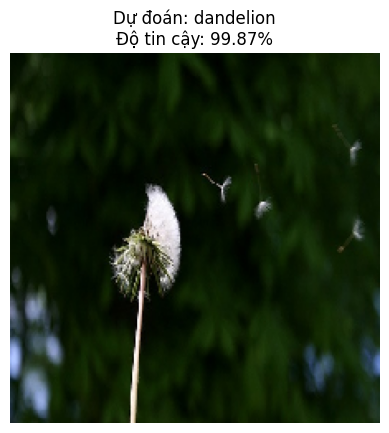

In [26]:
# Cell 15: Tải lại mô hình và thực hiện dự đoán

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Tải lại mô hình đã lưu ---
loaded_model = load_model("best_flower_model.keras")
print("Đã tải lại mô hình từ file.")

# --- 2. Chuẩn bị hàm dự đoán ---
# Hàm này sẽ lấy đường dẫn ảnh, tiền xử lý và dự đoán
def predict_with_best_model(img_path):
    # Tải và resize ảnh
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Chuyển ảnh thành mảng numpy
    img_array = image.img_to_array(img)

    # Thêm một chiều để tạo thành một lô (batch) chỉ có 1 ảnh
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # TIỀN XỬ LÝ ẢNH THEO ĐÚNG CHUẨN CỦA EFFICIENTNET
    processed_img = efficientnet_preprocess_input(img_array_expanded)

    # Thực hiện dự đoán
    prediction = loaded_model.predict(processed_img)

    # Lấy tên lớp có xác suất cao nhất
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Hiển thị ảnh và kết quả
    plt.imshow(img)
    plt.title(f"Dự đoán: {predicted_class_name}\nĐộ tin cậy: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

# --- 3. Thực hiện dự đoán ---
# THAY ĐỔI ĐƯỜNG DẪN NÀY đến ảnh test của bạn
# Ví dụ: '/kaggle/input/flowers-dataset/test/sunflower_test.jpg'
test_image_path = '/kaggle/input/flowers-dataset/test/Image_114.jpg' # <-- THAY ĐỔI ĐƯỜNG DẪN NÀY

try:
    predict_with_best_model(test_image_path)
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{test_image_path}'. Vui lòng kiểm tra lại đường dẫn.")

# So sánh hiệu suất các mô hình

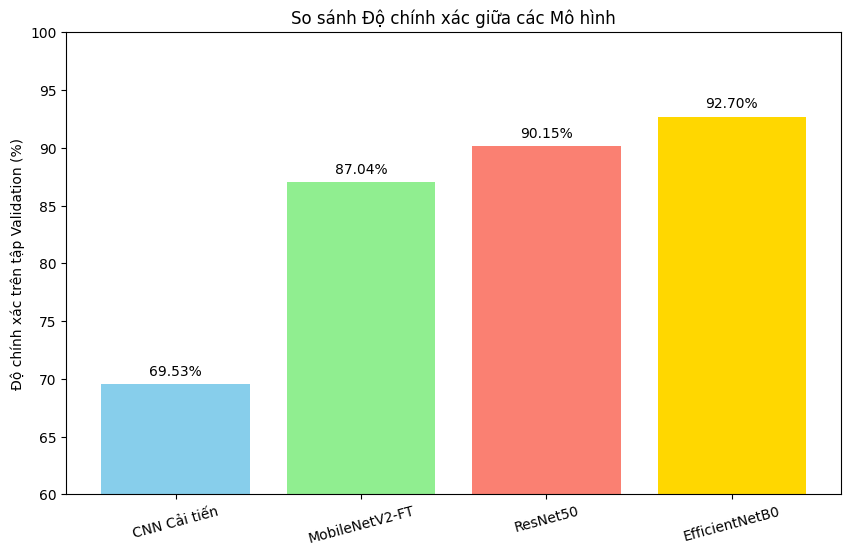


--- Phân tích chi tiết mô hình EfficientNetB0 ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step


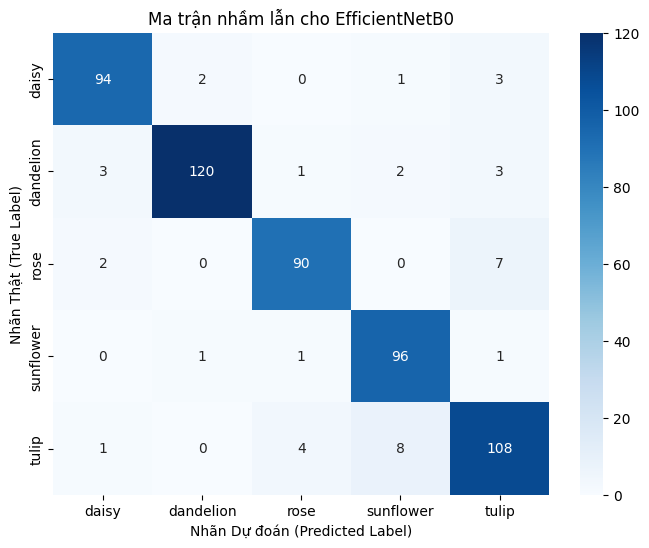


Báo cáo phân loại chi tiết cho EfficientNetB0:
              precision    recall  f1-score   support

       daisy       0.94      0.94      0.94       100
   dandelion       0.98      0.93      0.95       129
        rose       0.94      0.91      0.92        99
   sunflower       0.90      0.97      0.93        99
       tulip       0.89      0.89      0.89       121

    accuracy                           0.93       548
   macro avg       0.93      0.93      0.93       548
weighted avg       0.93      0.93      0.93       548



In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. BIỂU ĐỒ CỘT SO SÁNH ĐỘ CHÍNH XÁC ---

# Dữ liệu độ chính xác từ các bước huấn luyện trước đó của chúng ta
model_names = [
    'CNN Cải tiến', 
    'MobileNetV2-FT', 
    'ResNet50', 
    'EfficientNetB0'
]
accuracies = [
    69.53, # Kết quả từ Bước 3
    87.04, # Kết quả từ Bước 3.2 (Fine-tuning)
    90.15, # Kết quả từ Bước 4
    92.70  # Kết quả từ Bước 5
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylabel('Độ chính xác trên tập Validation (%)')
plt.title('So sánh Độ chính xác giữa các Mô hình')
plt.ylim(60, 100) # Đặt giới hạn trục y để thấy rõ sự khác biệt

# Thêm nhãn số liệu trên mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=15)
plt.show()


# --- 2. MA TRẬN NHẦM LẪN CHO MÔ HÌNH TỐT NHẤT (EfficientNetB0) ---

print("\n--- Phân tích chi tiết mô hình EfficientNetB0 ---")

# Lấy các nhãn dự đoán và nhãn thật từ validation_generator của EfficientNetB0
Y_pred_probs = model_efficientnet.predict(validation_generator_efficientnet)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = validation_generator_efficientnet.classes

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(Y_true, Y_pred)

# Vẽ ma trận
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn cho EfficientNetB0')
plt.ylabel('Nhãn Thật (True Label)')
plt.xlabel('Nhãn Dự đoán (Predicted Label)')
plt.show()

# In báo cáo phân loại chi tiết
print("\nBáo cáo phân loại chi tiết cho EfficientNetB0:")
print(classification_report(Y_true, Y_pred, target_names=class_names))

--- Phân tích chi tiết mô hình CNN Cải tiến (độ chính xác: 69.53%) ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 392ms/step


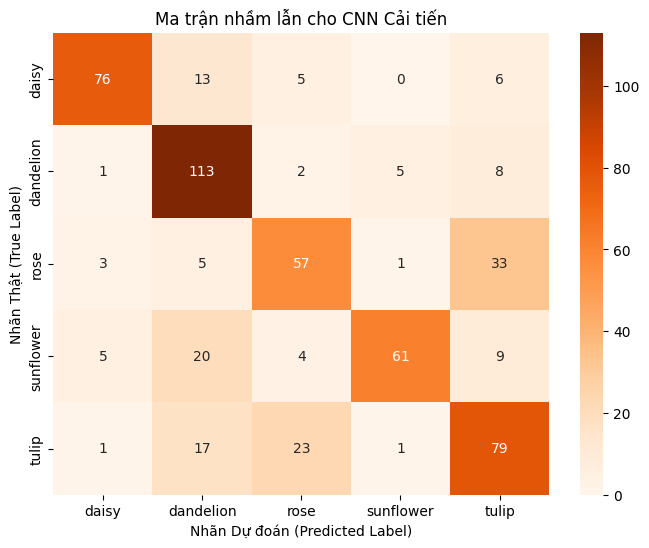


Báo cáo phân loại cho CNN Cải tiến:
              precision    recall  f1-score   support

       daisy       0.88      0.76      0.82       100
   dandelion       0.67      0.88      0.76       129
        rose       0.63      0.58      0.60        99
   sunflower       0.90      0.62      0.73        99
       tulip       0.59      0.65      0.62       121

    accuracy                           0.70       548
   macro avg       0.73      0.70      0.71       548
weighted avg       0.72      0.70      0.70       548



--- Phân tích chi tiết mô hình MobileNetV2 Fine-tuned (độ chính xác: 87.04%) ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step


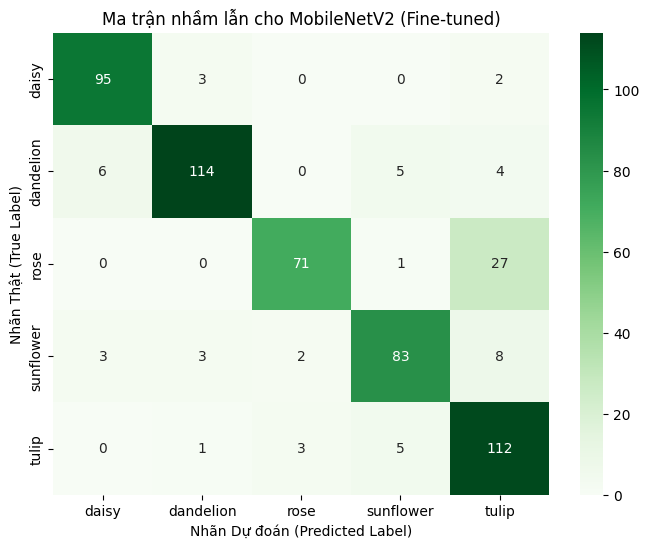


Báo cáo phân loại cho MobileNetV2 (Fine-tuned):
              precision    recall  f1-score   support

       daisy       0.91      0.95      0.93       100
   dandelion       0.94      0.88      0.91       129
        rose       0.93      0.72      0.81        99
   sunflower       0.88      0.84      0.86        99
       tulip       0.73      0.93      0.82       121

    accuracy                           0.87       548
   macro avg       0.88      0.86      0.87       548
weighted avg       0.88      0.87      0.87       548



--- Phân tích chi tiết mô hình ResNet50 (độ chính xác: 90.15%) ---
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step


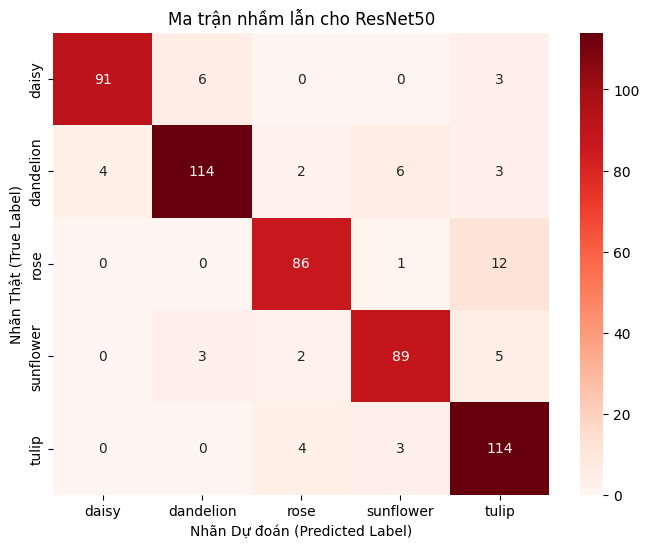


Báo cáo phân loại cho ResNet50:
              precision    recall  f1-score   support

       daisy       0.96      0.91      0.93       100
   dandelion       0.93      0.88      0.90       129
        rose       0.91      0.87      0.89        99
   sunflower       0.90      0.90      0.90        99
       tulip       0.83      0.94      0.88       121

    accuracy                           0.90       548
   macro avg       0.91      0.90      0.90       548
weighted avg       0.90      0.90      0.90       548



In [28]:
# Cell 17: Vẽ ma trận nhầm lẫn cho các mô hình còn lại

# --- 1. Phân tích mô hình CNN Cải tiến ---
print("--- Phân tích chi tiết mô hình CNN Cải tiến (độ chính xác: 69.53%) ---")
Y_true_cnn = validation_generator.classes
Y_pred_probs_cnn = model.predict(validation_generator)
Y_pred_cnn = np.argmax(Y_pred_probs_cnn, axis=1)

cm_cnn = confusion_matrix(Y_true_cnn, Y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn cho CNN Cải tiến')
plt.ylabel('Nhãn Thật (True Label)')
plt.xlabel('Nhãn Dự đoán (Predicted Label)')
plt.show()

print("\nBáo cáo phân loại cho CNN Cải tiến:")
print(classification_report(Y_true_cnn, Y_pred_cnn, target_names=class_names))


# --- 2. Phân tích mô hình MobileNetV2 (Fine-tuned) ---
print("\n\n--- Phân tích chi tiết mô hình MobileNetV2 Fine-tuned (độ chính xác: 87.04%) ---")
# Sử dụng lại validation_generator tương ứng lúc huấn luyện
Y_true_mobilenet = validation_generator.classes 
Y_pred_probs_mobilenet = model_mobilenet.predict(validation_generator)
Y_pred_mobilenet = np.argmax(Y_pred_probs_mobilenet, axis=1)

cm_mobilenet = confusion_matrix(Y_true_mobilenet, Y_pred_mobilenet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn cho MobileNetV2 (Fine-tuned)')
plt.ylabel('Nhãn Thật (True Label)')
plt.xlabel('Nhãn Dự đoán (Predicted Label)')
plt.show()

print("\nBáo cáo phân loại cho MobileNetV2 (Fine-tuned):")
print(classification_report(Y_true_mobilenet, Y_pred_mobilenet, target_names=class_names))


# --- 3. Phân tích mô hình ResNet50 ---
print("\n\n--- Phân tích chi tiết mô hình ResNet50 (độ chính xác: 90.15%) ---")
Y_true_resnet = validation_generator_resnet.classes
Y_pred_probs_resnet = model_resnet.predict(validation_generator_resnet)
Y_pred_resnet = np.argmax(Y_pred_probs_resnet, axis=1)

cm_resnet = confusion_matrix(Y_true_resnet, Y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Ma trận nhầm lẫn cho ResNet50')
plt.ylabel('Nhãn Thật (True Label)')
plt.xlabel('Nhãn Dự đoán (Predicted Label)')
plt.show()

print("\nBáo cáo phân loại cho ResNet50:")
print(classification_report(Y_true_resnet, Y_pred_resnet, target_names=class_names))